In [1]:
import numpy as np
import pandas as pd
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv("IMDB_Dataset.csv")[:10000]
dataset['sentiment'] = dataset['sentiment'].replace(['positive','negative'],[1, 0])
dataset

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
9995,"Fun, entertaining movie about WWII German spy ...",1
9996,Give me a break. How can anyone say that this ...,0
9997,This movie is a bad movie. But after watching ...,0
9998,This is a movie that was probably made to ente...,0


In [3]:
dataset.isnull().sum()

review       0
sentiment    0
dtype: int64

([<matplotlib.axis.XTick at 0x2599cccc430>,
 [Text(0, 0, ''), Text(0, 0, '')])

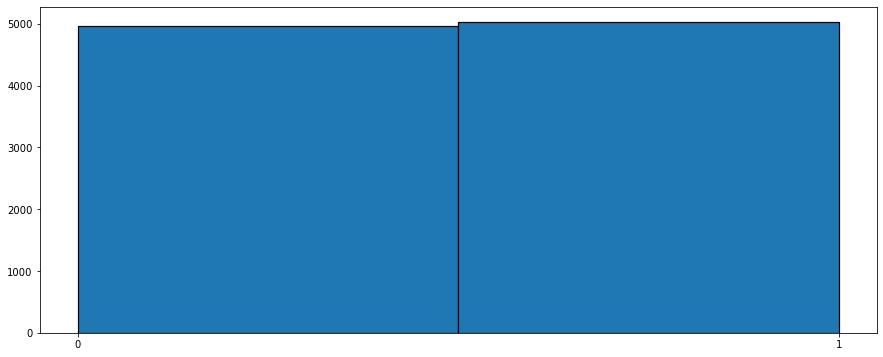

In [4]:
plt.figure(figsize=(15, 6))
plt.hist(dataset['sentiment'], bins=2, edgecolor='black', linewidth=1.2)
plt.xticks((0, 1))

In [5]:
def preprocess(text_data: pd.Series) -> CountVectorizer:
    corpus = []
    text_data = text_data.apply(func=clean_review)
    print(text_data)
    count_vectorizer = CountVectorizer(ngram_range=(2, 2))
    #features = count_vectorizer.fit_transform(text_data).toarray()
    count_vectorizer = count_vectorizer.fit(text_data)
    return count_vectorizer

In [6]:
def clean_review(text: str):
    """
    Receives a raw review and clean it using the following steps:
    1. Remove all non-words
    2. Transform the review in lower case
    3. Remove all stop words
    4. Perform stemming

    Args:
        text: the review that iwill be cleaned
    Returns:
        a clean review using the mentioned steps above.
    """
    text = re.sub(r"([.]{1,4})|(<br /><br />)|[^A-Za-z ]", " ", text)
    text = re.sub(r"\s+", " ", text)
    text = text.lower()
    text = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text if word not in set(stopwords.words("english"))]
    text = " ".join(text)
    return text

In [7]:
count_vectorizer = preprocess(text_data=dataset.review)
X_train, X_test, y_train, y_test = train_test_split(dataset.review,
                                                    dataset.sentiment,
                                                    test_size=0.2,
                                                    random_state=42)

0       one reviewer mentioned watching oz episode hoo...
1       wonderful little production filming technique ...
2       thought wonderful way spend time hot summer we...
3       basically family little boy jake think zombie ...
4       petter mattei love time money visually stunnin...
                              ...                        
9995    fun entertaining movie wwii german spy julie a...
9996    give break anyone say good hockey movie know m...
9997    movie bad movie watching endless series bad ho...
9998    movie probably made entertain middle school ea...
9999    smashing film film making show intense strange...
Name: review, Length: 10000, dtype: object


In [8]:
len(count_vectorizer.vocabulary_)

769321

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
def generate_batch(x, y, batch_size):
    """  Yields batch of specified size """
    for i in range(0, len(x), batch_size):
        yield x[i : i + batch_size], y[i : i + batch_size]

In [23]:
random_forest = RandomForestClassifier(warm_start=True,
                                       n_estimators=100,
                                       criterion='entropy',
                                       random_state=42,
                                       )

gen = generate_batch(X_train, y_train, batch_size=1024)
for x, y in gen:
    transformed_array = count_vectorizer.transform(x).toarray()
    random_forest.fit(X=transformed_array,
                      y=y)
    score = random_forest.score(X=transformed_array,
                                y=y)
    random_forest.n_estimators += 50
    print(score)

gen = generate_batch(X_test, y_test, batch_size=256)
score = []
for x, y in gen:
    score.append(random_forest.score(X=count_vectorizer.transform(x).toarray(),
                                     y=y))
    print(score)
np.mean(score)

1.0
0.775390625
0.9423828125
0.92578125
0.8544921875
0.8125
0.744140625
0.7223557692307693
[0.51953125]
[0.51953125, 0.63671875]
[0.51953125, 0.63671875, 0.58984375]
[0.51953125, 0.63671875, 0.58984375, 0.640625]
[0.51953125, 0.63671875, 0.58984375, 0.640625, 0.60546875]
[0.51953125, 0.63671875, 0.58984375, 0.640625, 0.60546875, 0.64453125]
[0.51953125, 0.63671875, 0.58984375, 0.640625, 0.60546875, 0.64453125, 0.59765625]
[0.51953125, 0.63671875, 0.58984375, 0.640625, 0.60546875, 0.64453125, 0.59765625, 0.5721153846153846]


0.6008112980769231

In [12]:
gen = generate_batch(X_test, y_test, batch_size=256)
score = []
for x, y in gen:
    score.append(random_forest.score(X=count_vectorizer.transform(x).toarray(),
                                     y=y))
np.mean(score)

0.6636868990384616